In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('..')

In [7]:
x = np.arange(1, 10)
y = x * 10
data = pd.DataFrame(data={'x': x, 'y': y})

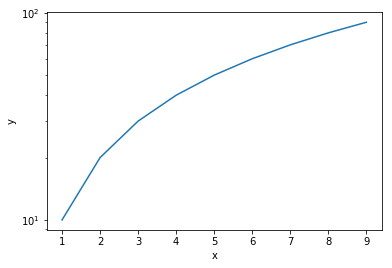

In [8]:
fig = plt.figure().add_axes()
ax = plt.gca()
ax.set(yscale='log')
sns.lineplot(x='x', y='y', data=data)

In [13]:
from utils.io import load
fn = '/Users/stathis/Code/thesis/wave_propagation/experiments_results/convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001//pickles/metadata.pickle.json'

In [14]:
# load(fn)

In [15]:
import json
import jsons
with open(fn) as f:
    dd = json.load(f)

In [16]:
import math 
num_total_frames = 100
num_output_frames = 10
num_input_frames = 5
for starting_point in range(0, num_total_frames, 10):
    num_requested_output_frames = math.floor(math.floor((num_total_frames - num_input_frames - 
                                              starting_point) / num_output_frames) * num_output_frames / 10) * 10
    print(starting_point, num_requested_output_frames)

0 90
10 80
20 70
30 60
40 50
50 40
60 30
70 20
80 10
90 0


In [22]:
from models.ConvLSTM import get_convlstm_model
modelCL = get_convlstm_model(5, 10, 2, 'cpu')
# summary(modelCL, (10,128,128), batch_size=16, device='cpu')

In [23]:
from torchsummary import summary

In [24]:
class argsclass():
    pass
args = argsclass()

In [71]:
import sys
sys.path.append('..')
sys.path.append('../..')
import logging
import torch
import os
import matplotlib.pyplot as plt
from models.ConvLSTM import get_convlstm_model
from utils.experiment import Experiment
from utils.arg_extract import get_args
plt.ioff()

logging.basicConfig(format='%(message)s', level=logging.INFO)

# args = get_args_test()
args.experiment_name='convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001' 
args.num_workers = 1
args.batch_size=1
args.normalizer_type='normal'
args.test_starting_point=15
args.show_plots=True
args.debug=True
args.num_epochs = 100
args.dataset='original'

experiment = Experiment(args)
experiment.load_from_disk(test=True)

Experiment convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001
Creating directories
use CPU
Loading datasets
Loading model /Users/stathis/Code/thesis/wave_propagation/experiments_results/convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001/models/model_best.pt


In [72]:
experiment.model

EncoderForecaster(
  (encoder): Encoder(
    (stage1): Sequential(
      (conv1_leaky_1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_conv1_leaky_1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (rnn1): ConvLSTMCell(
      (_conv): Conv2d(72, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (stage2): Sequential(
      (conv2_leaky_1): Conv2d(64, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_conv2_leaky_1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (rnn2): ConvLSTMCell(
      (_conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (stage3): Sequential(
      (conv3_leaky_1): Conv2d(192, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (leaky_conv3_leaky_1): LeakyReLU(negative_slope=0.2, inplace)
    )
    (rnn3): ConvLSTMCell(
      (_conv): Conv2d(384, 768, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (forecaster): Forecaster(
    (rnn3): Con

In [73]:
batch = next(iter(experiment.dataloaders['train']))

In [74]:
batch.size()

torch.Size([1, 100, 128, 128])

In [77]:
from utils.helper_functions import convert_BSHW_to_SBCHW, convert_SBCHW_to_BSHW

In [80]:
experiment.model.encoder(convert_BSHW_to_SBCHW(batch))[0][0].size()

new forward
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])


torch.Size([1, 64, 64, 64])

In [91]:
experiment.model(batch).size()

new forward
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output: 

torch.Size([1, 10, 128, 128])

In [92]:
experiment.model.get_future_frames(batch, 15).size()

new forward
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output: 

torch.Size([1, 15, 128, 128])

In [82]:
from models.AR_ConvLSTM import get_ar_convlstm_model

In [83]:
ar_model = get_ar_convlstm_model(5, 10, 1, 'cpu')

In [93]:
ar_model(batch).size()

new forward
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 64, 64, 64])


torch.Size([1, 1, 128, 128])

In [95]:
ar_model.get_future_frames(batch, 15).size()

new forward
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 64, 64, 64])
CONVLSTM OUTPUT FRAMES SIZE torch.Size([1, 1, 128, 128])
new forward
convlstm output:  t

convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 64, 64, 64])
CONVLSTM OUTPUT FRAMES SIZE torch.Size([1, 9, 128, 128])
new forward
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
convlstm output:  torch.Size([1, 64, 64, 64])
new forward
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
convlstm output:  torch.Size([1, 192, 32, 32])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1, 192, 16, 16])
new forward
convlstm output:  torch.Size([1

torch.Size([1, 15, 128, 128])